In [33]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist.floating_axes as floating_axes
import mpl_toolkits.axisartist.angle_helper as angle_helper
from mpl_toolkits.axisartist.grid_finder import MaxNLocator
from matplotlib.transforms import Affine2D

from astropy import constants as const
from astropy.table import Table

import os
from astropy.io import fits
in_directory='/scratch/ierez/IGMCosmo/VoidFinder/data/DR16S82_H/delta_fields/'
os.chdir(in_directory)

## Data files

In [34]:
galaxy_filename = '/scratch/sbenzvi_lab/boss/dr16/delta_fields/deltafields_added90_fixed.fits' #delta_fields
quasars_filename='/scratch/sbenzvi_lab/boss/dr16/delta_fields/quasars.fits'
#void_filename = '/Users/kellydouglass/Documents/Research/Voids/VoidFinder/void_catalogs/SDSS/python_implementation/vollim_dr7_cbp_102709_comoving_maximal.txt'
void_filename = '/scratch/ierez/IGMCosmo/VoidFinder/outputs/delta_runs/deltafields_added90_fixed._redshift_maximal_noMagCut.txt'

## Import data

In [35]:
# Galaxy catalog
#galaxies = Table.read(galaxy_filename, format='ascii.commented_header', 
#                      include_names=['ra', 'dec', 'redshift', 'Rgal', 'vflag'])
galaxies = fits.open(galaxy_filename)  
galaxies=Table(galaxies[1].data)
galaxies['z'].name='redshift'
#rgal=Table.Column(1*np.ones(len(galaxies['ra'])), name='Rgal')
#galaxies.add_column(rgal)
vflag=Table.Column(np.zeros(len(galaxies['ra'])), name='vflag')
galaxies.add_column(vflag)
# Void catalog (detected voids, output of voidfinder)
voids = Table.read(void_filename, format='ascii.commented_header')

quasars = fits.open(quasars_filename)  
quasars=Table(quasars[1].data)
voids[0:5]

x,y,z,radius,flag,r,ra,dec
float64,float64,float64,float64,int64,float64,float64,float64
-2677.7247909158773,8061.727505133351,-0.9421354975408998,15.273567336893796,0,8494.802017147214,108.3740479925384,-0.00635451982756665
-4424.732952581056,8227.836330353715,-54.53395762651712,15.248415878933999,1,9342.297700955562,118.27029746484908,-0.3344555544027114
-2716.2512953153723,7901.562272549673,2.4027495125344913,14.850332031239303,2,8355.400242926009,108.97098667654488,0.016476458839815813
-4352.2018737143035,8093.705089772203,-53.60167284733581,14.69873820795416,3,9189.809376102356,118.26810915518823,-0.3341926820637362
-2946.2683534131725,8577.852369467186,1.5534567251959404,14.529213008896445,4,9069.732680510799,108.95625866387545,0.009813576384273295


## Shift ra's back for all

In [36]:
galaxies['ra'] = galaxies['ra']-90
quasars['ra'] = quasars['ra']-90
voids['ra'] = voids['ra']-90

## Convert redshift to distance
Going to plot $cz$ in km/s

Note: Multiply distances in Mpc/h by 100 ($= H_0 = 100h$) to convert to km/s.

In [37]:
c = const.c.to('km/s').value

galaxies['cz'] = c*galaxies['redshift']
H_0=100
quasars['cz'] = c*quasars['z']
#print(min(galaxies['Rgal']), max(galaxies['Rgal']))
print(min(voids['r']*100), max(voids['r']*100))
print(min(voids['radius']*100), max(voids['radius']*100))
voids[0:5]

630936.3495058822 942497.1883598547
1000.079046037427 1527.3567336893796


x,y,z,radius,flag,r,ra,dec
float64,float64,float64,float64,int64,float64,float64,float64
-2677.7247909158773,8061.727505133351,-0.9421354975408998,15.273567336893796,0,8494.802017147214,18.374047992538394,-0.00635451982756665
-4424.732952581056,8227.836330353715,-54.53395762651712,15.248415878933999,1,9342.297700955562,28.27029746484908,-0.3344555544027114
-2716.2512953153723,7901.562272549673,2.4027495125344913,14.850332031239303,2,8355.400242926009,18.970986676544882,0.016476458839815813
-4352.2018737143035,8093.705089772203,-53.60167284733581,14.69873820795416,3,9189.809376102356,28.268109155188228,-0.3341926820637362
-2946.2683534131725,8577.852369467186,1.5534567251959404,14.529213008896445,4,9069.732680510799,18.956258663875445,0.009813576384273295


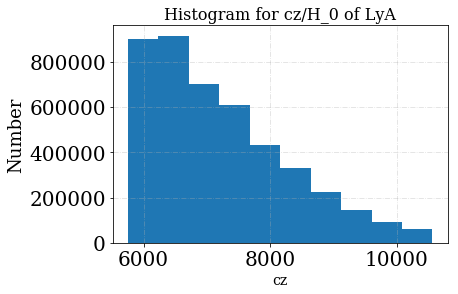

<Figure size 432x288 with 0 Axes>

In [38]:
#Histogram of redshift

plt.figure()                                                                                        
plt.rc('text', usetex=False)                                                                        
plt.rc('font', family='serif')                                                                      
                                                                                                    
plt.grid(True,ls='-.',alpha=.4)                                                                     
plt.title(r'Histogram for cz/H_0 of LyA',fontsize=16)                                         
plt.xlabel(r'cz',fontsize=14)                                                                       
plt.ylabel(r'Number',fontsize=18)                                                                   
                                                                                                    
plt.hist(galaxies['cz']/H_0 )#,bins=range(int(min(galaxies['cz'])), int(max(galaxies['cz'])) + 0.1, 0.1), color='teal')                                                                   \
                                                                                                    
#plt.hist(2*np.pi*data[1].data['ra'], color='teal')                                                  
plt.show()                                                                                          
                                                                                                    
plt.savefig('cz_distn.png')  

galaxies['r'] = galaxies['cz']/H_0

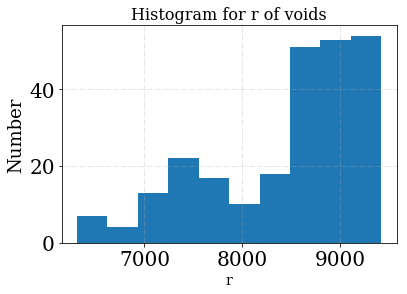

<Figure size 432x288 with 0 Axes>

In [39]:
#Histogram of redshift

plt.figure()                                                                                        
plt.rc('text', usetex=False)                                                                        
plt.rc('font', family='serif')                                                                      
                                                                                                    
plt.grid(True,ls='-.',alpha=.4)                                                                     
plt.title(r'Histogram for r of voids',fontsize=16)                                         
plt.xlabel(r'r',fontsize=14)                                                                       
plt.ylabel(r'Number',fontsize=18)                                                                   
                                                                                                    
plt.hist(voids['r'] )#,bins=range(int(min(galaxies['cz'])), int(max(galaxies['cz'])) + 0.1, 0.1), color='teal')                                                                   \
                                                                                                    
#plt.hist(2*np.pi*data[1].data['ra'], color='teal')                                                  
plt.show()                                                                                          
                                                                                                    
plt.savefig('cz_distn.png')

## Function to set up axes

Following matplotlib demo : https://matplotlib.org/examples/axes_grid/demo_floating_axes.html

In [40]:
def setup_axes3(fig, rect, ra0, ra1, cz0, cz1):
    
    # rotate a bit for better orientation
    tr_rotate = Affine2D().translate(-90, 0)
    
    # scale degree to radians
    tr_scale = Affine2D().scale(np.pi/180, 1)

    tr = tr_rotate + tr_scale + mpl.projections.PolarAxes.PolarTransform()
    
    grid_locator1 = angle_helper.LocatorHMS(4)
    tick_formatter1 = angle_helper.FormatterHMS()
    
    grid_locator2 = MaxNLocator(3)
    
    grid_helper = floating_axes.GridHelperCurveLinear(tr, extremes=(ra0, ra1, cz0, cz1),
                                                      grid_locator1=grid_locator1,
                                                      grid_locator2=grid_locator2,
                                                      tick_formatter1=tick_formatter1,
                                                      tick_formatter2=None)

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    fig.add_subplot(ax1)
    
    # adjust axis
    ax1.axis['left'].set_axis_direction('bottom')
    
    ax1.axis['right'].set_axis_direction('top')
    
    ax1.axis['bottom'].set_visible(False)
    
    ax1.axis['top'].set_axis_direction("bottom")
    ax1.axis['top'].toggle(ticklabels=True, label=True)
    ax1.axis['top'].major_ticklabels.set_axis_direction("top")
    ax1.axis['top'].label.set_axis_direction("top")
    
    #ax1.axis['left'].major_ticklabels.set_axis_direction('right')
    ax1.axis["left"].label.set_text("cz [km/s]")
    
    aux_ax = ax1.get_aux_axes(tr)

    aux_ax.patch = ax1.patch  
    ax1.patch.zorder = 0.9  

    return ax1, aux_ax

## Wedge plot

In [41]:
# 'd' is declination and 's' is the thickness of the declination slice
# Vary 'd' and 's' to get difference slices.
d,s = -1.25, 2.5

# slice center, can use this for analysis since the slice thickness is very small.
slice_= d + 0.5*s


################################################################################
# Remove galaxies outside declination range
#-------------------------------------------------------------------------------
galaxies_dec_cut = np.logical_and(galaxies['dec'] > d, 
                                  galaxies['dec'] <= d+s)
galaxies_dec_slice = galaxies[galaxies_dec_cut]
################################################################################


################################################################################
# Remove galaxies outside distance range
#-------------------------------------------------------------------------------
cz_min, cz_max = min(quasars['z'])*c, max(quasars['z'])*c #32700

galaxies_dist_boolean = np.logical_and(galaxies_dec_slice['cz'] > cz_min, 
                                       galaxies_dec_slice['cz'] <= cz_max)
galaxies_sample = galaxies_dec_slice[galaxies_dist_boolean]
################################################################################


################################################################################
# Voids that intersect the slice
#-------------------------------------------------------------------------------
dec_intersect_cut = np.sin(np.abs(slice_ - voids['dec'])*np.pi/180)*voids['r'] <= voids['radius']
void_sample = voids[dec_intersect_cut]

# Radius of void at intersection
void_sample['radius_intersect'] = np.sqrt(void_sample['radius']**2 
                                          - (np.sin(np.abs(slice_ - void_sample['dec'])*np.pi/180)*void_sample['r'])**2)
################################################################################


################################################################################
# Transform hole centers from (ra, r) to (x, y)
#-------------------------------------------------------------------------------
void_sample['x_polar'] = 100*void_sample['r']*np.cos(void_sample['ra']*np.pi/180 - 0.5*np.pi)
void_sample['y_polar'] = 100*void_sample['r']*np.sin(void_sample['ra']*np.pi/180 - 0.5*np.pi)
################################################################################


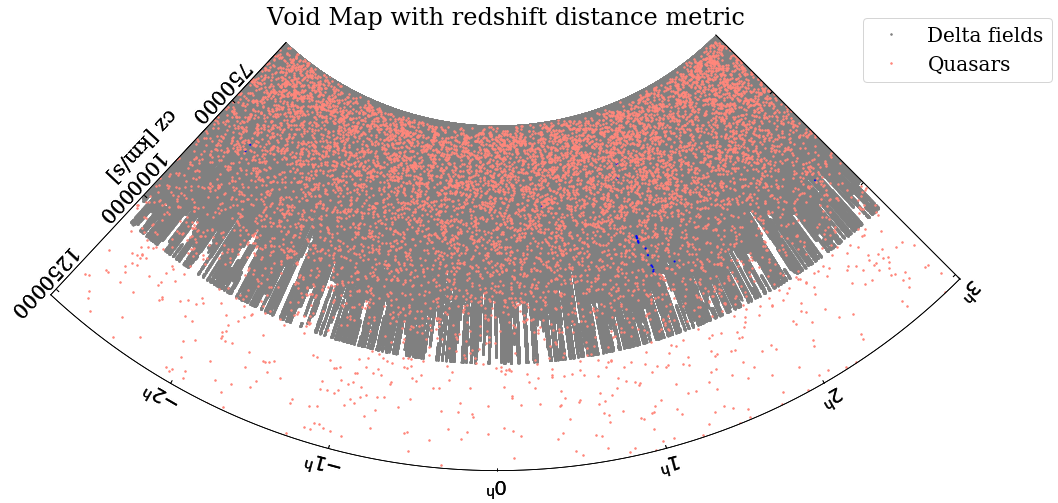

In [42]:
fig = plt.figure(figsize=(15,8))

# Range of RA to use in plot
ra_min, ra_max = -43, 45

ax, aux_ax = setup_axes3(fig, 111, ra_min, ra_max, cz_min, cz_max)


# Galaxies

#aux_ax.plot(galaxies_sample['ra'][galaxies_sample['vflag'] == 0], 
#            galaxies_sample['cz'][galaxies_sample['vflag'] == 0], 
#            '.', c='0.5', ms=3, zorder=1, label='Wall')
#            #'.', c='0.5', zorder=1, label='Wall')
#aux_ax.plot(galaxies_sample['ra'][galaxies_sample['vflag'] == 1], 
#            galaxies_sample['cz'][galaxies_sample['vflag'] == 1], 
#            '.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
#            #'.', c=(1,135/255,123/255), zorder=2, label='Void')

aux_ax.plot(galaxies_sample['ra'], 
            galaxies_sample['cz'], 
            #'.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
            '.', c='0.5', ms=3, zorder=1, label='Delta fields')
            #'.', c='0.5', zorder=1, label='Wall')
aux_ax.plot(quasars['ra'], 
            quasars['cz'], 
            '.', c=(1,135/255,123/255), ms=3, zorder=2, label='Quasars')
  
# Voids
holes = [plt.Circle((x,y), radius=r*100, transform=aux_ax.transData._b, fill=False, ec='b') 
         for x,y,r in zip(void_sample['x_polar'], void_sample['y_polar'], void_sample['radius_intersect'])]
for hole in holes:
    aux_ax.add_artist(hole)
'''
aux_ax.scatter(void_sample['ra'], void_sample['r']*100, edgecolors='b', 
               s=void_sample['radius_intersect']*100, facecolors='none', 
               linewidth=1.5, zorder=3)
'''
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Void Map with redshift distance metric')
mpl.rc('font', size=20)

plt.tight_layout();

plt.savefig('DR16_deltafields_redshift.eps', format='eps', dpi=300)

plt.figure()
plt.plot(galaxies['cz'], galaxies['Rgal']*100, '.')
plt.plot([0,140000],[0,140000], 'r:');

void_sample[:10]

In [43]:
len(voids['r'])

249

In [44]:
len(quasars) #8199

9642

In [45]:
len(galaxies)

4407482

In [46]:
max(quasars['z']) #3.2

4.21668863296509

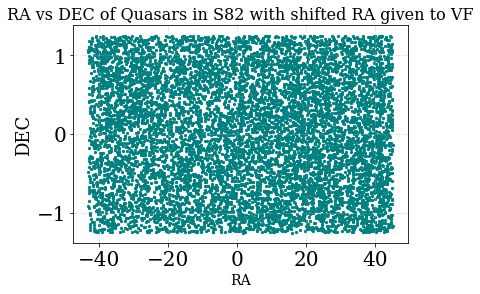

In [47]:
#Plot footprint of quasars
plt.figure()
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

plt.grid(True,ls='-.',alpha=.4)
plt.title(r'RA vs DEC of Quasars in S82 with shifted RA given to VF',fontsize=16)
plt.xlabel(r'RA',fontsize=14)
plt.ylabel(r'DEC',fontsize=18)

plt.scatter(quasars['ra'],quasars['dec'], color='teal', s=5, label='Stripe 82')
plt.show()

#plt.savefig(out_directory+'ravsdec_shifted_VF.png')

In [48]:
min(quasars['z']) #2.1

1.994

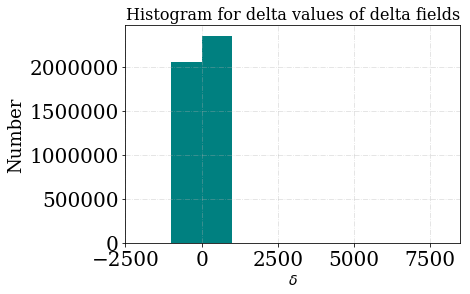

In [60]:
#Histogram of delta values

plt.figure()                                                                                        
plt.rc('text', usetex=False)                                                                        
plt.rc('font', family='serif')                                                                      
                                                                                                    
plt.grid(True,ls='-.',alpha=.4)                                                                     
plt.title(r'Histogram for delta values of delta fields',fontsize=16)                                         
plt.xlabel(r'$\delta$',fontsize=14)                                                                       
plt.ylabel(r'Number',fontsize=18)                                                                   
                                                                                                    
plt.hist(galaxies['delta'] ,bins=range(-2000, 9000, 1000), color='teal')                                                                   \
                                                                                                    
#plt.hist(2*np.pi*data[1].data['ra'], color='teal')                                                  
plt.show()                                                                                          
                                                                                                    
#plt.savefig('cz_distn.png')  
#max(quasars['comoving'])

In [55]:
min(galaxies['delta'])

-18291.021180129555

In [56]:
max(galaxies['delta'])

8665.70026792556

In [57]:
galaxies[0:5]

ra,dec,redshift,delta,vflag,cz,r
float64,float64,float64,float64,float64,float64,float64
-34.90196644835447,-1.1593308268464853,3.0846264465874778,-2.6700565094875603,0.0,924747.7444342657,9247.477444342656
-34.90196644835447,-1.1593308268464853,3.0855670748737936,-1.4396249644115322,0.0,925029.7377002846,9250.297377002846
-34.90196644835447,-1.1593308268464853,3.0865079197727097,-0.45740696573626016,0.0,925311.7959051274,9253.117959051275
-34.90196644835447,-1.1593308268464853,3.087448981334117,4.137706831117744,0.0,925593.919063751,9255.93919063751
-34.90196644835447,-1.1593308268464853,3.088390259607901,1.155314062862347,0.0,925876.1071911107,9258.761071911107


In [91]:
delta=galaxies['delta']
len(delta[delta<10])
delta=delta[delta<1]
delta=delta[delta>-1]
len(delta)

3346344

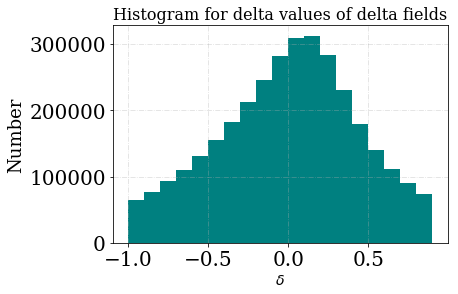

In [92]:
#Histogram of delta values

plt.figure()                                                                                        
plt.rc('text', usetex=False)                                                                        
plt.rc('font', family='serif')                                                                      
                                                                                                    
plt.grid(True,ls='-.',alpha=.4)                                                                     
plt.title(r'Histogram for delta values of delta fields',fontsize=16)                                         
plt.xlabel(r'$\delta$',fontsize=14)                                                                       
plt.ylabel(r'Number',fontsize=18)                                                                   
                                                                                                    
plt.hist(delta,bins=np.arange(-1, 1, 0.1), color='teal')                                                                   \
                                                                                                    
#plt.hist(2*np.pi*data[1].data['ra'], color='teal')                                                  
plt.show()                                                                                          
                                                                                                    
#plt.savefig('cz_distn.png')  
#max(quasars['comoving'])

In [93]:
(len(galaxies['delta'])-len(delta))

1061138

In [94]:
(len(galaxies['delta'])-len(delta))/len(galaxies['delta'])

0.2407583286783701

In [95]:
delta=galaxies['delta']
len(delta[delta<10])
delta=delta[delta<5]
delta=delta[delta>-5]
len(delta)

4275338

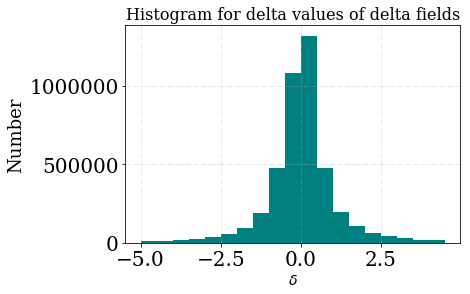

In [96]:
#Histogram of delta values

plt.figure()                                                                                        
plt.rc('text', usetex=False)                                                                        
plt.rc('font', family='serif')                                                                      
                                                                                                    
plt.grid(True,ls='-.',alpha=.4)                                                                     
plt.title(r'Histogram for delta values of delta fields',fontsize=16)                                         
plt.xlabel(r'$\delta$',fontsize=14)                                                                       
plt.ylabel(r'Number',fontsize=18)                                                                   
                                                                                                    
plt.hist(delta,bins=np.arange(-5, 5, 0.5), color='teal')                                                                   \
                                                                                                    
#plt.hist(2*np.pi*data[1].data['ra'], color='teal')                                                  
plt.show()                                                                                          
                                                                                                    
#plt.savefig('cz_distn.png')  
#max(quasars['comoving'])

In [97]:
(len(galaxies['delta'])-len(delta))

132144

In [98]:
(len(galaxies['delta'])-len(delta))/len(galaxies['delta'])

0.029981744678707706

In [99]:
delta=galaxies['delta']
len(delta[delta<10])
delta=delta[delta<0.2]
delta=delta[delta>-0.2]
len(delta)

1150709